In [577]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

In [578]:
pd.options.mode.chained_assignment = None

In [579]:
def load_and_prepare_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Select only the necessary columns
    wind_data = data[['period_end', 'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m']]
    
    # Convert 'period_end' to datetime
    wind_data['period_end'] = pd.to_datetime(wind_data['period_end'])
    
    return wind_data

In [580]:
def process_wind_data(wind_data, year):
    # Extract data for the given year
    start_date = f'{year}-01-01'
    end_date = f'{year+1}-01-01'
    wind_data_year = wind_data[(wind_data['period_end'] >= start_date) & (wind_data['period_end'] < end_date)]
    
    # Ensure the data types are correct
    wind_data_year['wind_speed_10m'] = wind_data_year['wind_speed_10m'].astype(float)
    wind_data_year['wind_speed_100m'] = wind_data_year['wind_speed_100m'].astype(float)
   
   # Constants
    k = 0.41
    z = 100
    z0 = 0.5
    d = 10.625
    
    # Heights of the wind turbines
    heights = {
        'Alstom_ECO122': 89, # https://en.wind-turbine-models.com/turbines/629-alstom-eco-122-2700
        'Enercon_E33': 50, # https://en.wind-turbine-models.com/turbines/369-enercon-e-30-330
        'Aventa_AV7': 18 # https://en.wind-turbine-models.com/turbines/1529-aventa-av-7
    }
    
    # Calculate u_star and add as a new column
    wind_data_year['u_star'] = (wind_data_year['wind_speed_100m'] * k) / np.log((z - d) / z0)
    
    # Calculate wind speed at specific heights using the log profile formula
    for turbine, height in heights.items():
        wind_data_year[f'wind_speed_{turbine}'] = (wind_data_year['u_star'] / k) * np.log((height - d) / z0)
    
    # Power curves
    power_curves = {
        'Alstom_ECO122': {'rated_power': 2700, 'cut_in': 3, 'cut_out': 25},
        'Enercon_E33': {'rated_power': 335, 'cut_in': 3, 'cut_out': 25},
        'Aventa_AV7': {'rated_power': 6.2, 'cut_in': 2, 'cut_out': 14}
    }
    
    # Function to calculate power based on the power curve
    def calculate_power(wind_speed, power_curve):
        if wind_speed < power_curve['cut_in'] or wind_speed > power_curve['cut_out']:
            return 0
        elif wind_speed >= power_curve['cut_in'] and wind_speed < power_curve['rated_power']:
            return (power_curve['rated_power'] / (power_curve['cut_out'] - power_curve['cut_in'])) * (wind_speed - power_curve['cut_in'])
        else:
            return power_curve['rated_power']
    
    # Calculate power production for each turbine
    for turbine, power_curve in power_curves.items():
        wind_data_year[f'power_{turbine}'] = wind_data_year[f'wind_speed_{turbine}'].apply(calculate_power, power_curve=power_curve)
    
    # Calculate total power production in kWh/year
    total_hours = wind_data_year.shape[0] * 0.5  # each row represents 30 minutes
    total_power_production = {}
    for turbine in heights.keys():
        total_power_production[turbine] = wind_data_year[f'power_{turbine}'].sum() * 0.5  # in kWh
    
    # Calculate number of operating hours and capacity factor
    operating_hours = {}
    capacity_factor = {}
    for turbine, power_curve in power_curves.items():
        operating_hours[turbine] = wind_data_year[wind_data_year[f'wind_speed_{turbine}'] >= power_curve['cut_in']].shape[0] * 0.5
        capacity_factor[turbine] = (total_power_production[turbine] / (power_curve['rated_power'] * total_hours)) * 100
    
    # Prepare results DataFrame
    results = pd.DataFrame({
        'Turbine': list(heights.keys()),
        'Operating Hours': [operating_hours[turbine] for turbine in heights.keys()],
        'Total Power Production (kWh/year)': [total_power_production[turbine] for turbine in heights.keys()],
        'Capacity Factor (%)': [capacity_factor[turbine] for turbine in heights.keys()]
    })
    
    return wind_data_year, results
    


In [581]:
def process_wind_data2(wind_data):
    # Ensure the data types are correct
    wind_data['wind_speed_10m'] = wind_data['wind_speed_10m'].astype(float)
    wind_data['wind_speed_100m'] = wind_data['wind_speed_100m'].astype(float)
    
    # Constants
    k = 0.41
    z = 100
    z0 = 0.5
    d = 10.625
    
    # Heights of the wind turbines
    heights = {
        'Alstom_ECO122': 89, # https://en.wind-turbine-models.com/turbines/629-alstom-eco-122-2700
        'Enercon_E33': 50, # https://en.wind-turbine-models.com/turbines/369-enercon-e-30-330
        'Aventa_AV7': 18 # https://en.wind-turbine-models.com/turbines/1529-aventa-av-7
    }
    
    # Calculate u_star and add as a new column
    wind_data['u_star'] = (wind_data['wind_speed_100m'] * k) / np.log((z - d) / z0)
    
    # Calculate wind speed at specific heights using the log profile formula
    for turbine, height in heights.items():
        wind_data[f'wind_speed_{turbine}'] = (wind_data['u_star'] / k) * np.log((height - d) / z0)
    
    # Power curves
    power_curves = {
        'Alstom_ECO122': {'rated_power': 2700, 'cut_in': 3, 'cut_out': 25},
        'Enercon_E33': {'rated_power': 335, 'cut_in': 3, 'cut_out': 25},
        'Aventa_AV7': {'rated_power': 6.2, 'cut_in': 2, 'cut_out': 14}
    }
    
    # Function to calculate power based on the power curve
    def calculate_power(wind_speed, power_curve):
        if wind_speed < power_curve['cut_in'] or wind_speed > power_curve['cut_out']:
            return 0
        elif wind_speed >= power_curve['cut_in'] and wind_speed < power_curve['rated_power']:
            return (power_curve['rated_power'] / (power_curve['cut_out'] - power_curve['cut_in'])) * (wind_speed - power_curve['cut_in'])
        else:
            return power_curve['rated_power']
    
    # Calculate power production for each turbine
    for turbine, power_curve in power_curves.items():
        wind_data[f'power_{turbine}'] = wind_data[f'wind_speed_{turbine}'].apply(calculate_power, power_curve=power_curve)
    
    return wind_data

In [582]:
def plot_wind_features(wind_data_year):
    # Plot the wind-related features
    plt.figure(figsize=(14, 8))

    # Wind Speed at 10m and 100m
    plt.plot(wind_data_year['period_end'], wind_data_year['wind_speed_10m'], label='Wind Speed 10m')
    plt.plot(wind_data_year['period_end'], wind_data_year['wind_speed_100m'], label='Wind Speed 100m')

    # Wind Direction at 10m and 100m
    plt.plot(wind_data_year['period_end'], wind_data_year['wind_direction_10m'], label='Wind Direction 10m', alpha=0.7)
    plt.plot(wind_data_year['period_end'], wind_data_year['wind_direction_100m'], label='Wind Direction 100m', alpha=0.7)

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Wind-related Features Over One Year')
    plt.legend()
    plt.grid(True)
    plt.show()

In [583]:
def calculate_no_wind_hours(wind_data_year):
    # Calculate the number of periods where wind speed is zero at both 10m and 100m
    no_wind_periods = wind_data_year[(wind_data_year['wind_speed_10m'] == 0) & (wind_data_year['wind_speed_100m'] == 0)]

    # Calculate the number of hours
    # Each period is 30 minutes, so number of hours is number of periods divided by 2
    no_wind_hours = len(no_wind_periods) / 2

    return no_wind_hours

In [584]:
def calculate_low_wind_hours(wind_data_year, threshold=2):
    # Calculate the number of periods where wind speed is below or equal to the threshold at both 10m and 100m
    low_wind_periods = wind_data_year[(wind_data_year['wind_speed_10m'] <= threshold) & (wind_data_year['wind_speed_100m'] <= threshold)]

    # Calculate the number of hours
    # Each period is 30 minutes, so the number of hours is the number of periods divided by 2
    low_wind_hours = len(low_wind_periods) / 2

    return low_wind_hours

In [585]:
def plot_monthly_averages(wind_data_year):
    # Extract the month from the 'period_end'
    wind_data_year['month'] = wind_data_year['period_end'].dt.month

    # Select only numeric columns for averaging
    numeric_cols = wind_data_year.select_dtypes(include='number').columns

    # Calculate the monthly averages for numeric columns
    monthly_avg = wind_data_year.groupby('month')[numeric_cols].mean()

    # Plot the monthly-averaged wind-related features
    plt.figure(figsize=(14, 8))

    # Wind Speed at 10m and 100m
    plt.plot(monthly_avg.index, monthly_avg['wind_speed_10m'], label='Wind Speed 10m')
    plt.plot(monthly_avg.index, monthly_avg['wind_speed_100m'], label='Wind Speed 100m')

    # Wind Direction at 10m and 100m
    plt.plot(monthly_avg.index, monthly_avg['wind_direction_10m'], label='Wind Direction 10m', alpha=0.7)
    plt.plot(monthly_avg.index, monthly_avg['wind_direction_100m'], label='Wind Direction 100m', alpha=0.7)

    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.title('Monthly Averaged Wind-related Features')
    plt.legend()
    plt.grid(True)
    plt.show()

In [586]:
def plot_wind_speed_distribution(wind_data_year):
    # Plot the wind speed distribution
    plt.figure(figsize=(14, 8))

    # Wind Speed at 10m
    plt.hist(wind_data_year['wind_speed_10m'], bins=50, alpha=0.7, label='Wind Speed 10m')

    # Wind Speed at 100m
    plt.hist(wind_data_year['wind_speed_100m'], bins=50, alpha=0.7, label='Wind Speed 100m')

    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Frequency')
    plt.title('Wind Speed Distribution at 10m and 100m')
    plt.legend()
    plt.grid(True)
    plt.show()

In [587]:
def fit_weibull_distribution(wind_data_year):
    # Fit the Weibull distribution to the wind speed data
    wind_speed_10m = wind_data_year['wind_speed_10m']
    wind_speed_100m = wind_data_year['wind_speed_100m']

    # Fit Weibull distribution to wind speed at 10m
    params_10m = weibull_min.fit(wind_speed_10m, floc=0)
    shape_10m, loc_10m, scale_10m = params_10m

    # Fit Weibull distribution to wind speed at 100m
    params_100m = weibull_min.fit(wind_speed_100m, floc=0)
    shape_100m, loc_100m, scale_100m = params_100m

    return (shape_10m, loc_10m, scale_10m), (shape_100m, loc_100m, scale_100m)

    

In [588]:
# Import the pandas library
import pandas as pd

# Declaration of the different turbines dataframes
dict_eco122 = {1:0, 2:0, 3:29, 4:171, 5:389, 6:703, 7:1139, 8:1682, 9:2205, 10:2541,
                11:2669, 12:2697, 13:2700, 14:2700, 15:2700, 16:2700, 17:2700, 18:2700, 19:2700, 20:2700,
                21:2700, 22:2700, 23:2700, 24:2700, 25:2700, 26:0, 27:0, 28:0, 29:0, 30:0}
df_eco122 = pd.DataFrame(list(dict_eco122.items()), columns=["wind_speed_in_m_per_s", "power_in_kW"], dtype='float')

dict_E33 = {1:0, 2:0, 3:5, 4:13.7, 5:30, 6:55, 7:92, 8:138, 9:196, 10:250,
                11:292.8, 12:320, 13:335, 14:335, 15:335, 16:335, 17:335, 18:335, 19:335, 20:335,
                21:335, 22:335, 23:335, 24:335, 25:335, 26:0, 27:0, 28:0, 29:0, 30:0}
df_E33 = pd.DataFrame(list(dict_E33.items()), columns=["wind_speed_in_m_per_s", "power_in_kW"], dtype='float')

dict_AV7 = {1:0, 2:0.1, 3:0.7, 4:1.5, 5:3.1, 6:5.8, 7:6.2, 8:6.2, 9:6.2, 10:6.2,
                11:6.2, 12:6.2, 13:6.2, 14:6.2, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0,
                21:0, 22:0, 23:0, 24:0, 25:0, 26:0, 27:0, 28:0, 29:0, 30:0}
df_AV7 = pd.DataFrame(list(dict_AV7.items()), columns=["wind_speed_in_m_per_s", "power_in_kW"], dtype='float')

# Visualize the first five rows of the dataframe
df_eco122.head(5)

,wind_speed_in_m_per_s,power_in_kW
0,1.0,0.0
1,2.0,0.0
2,3.0,29.0
3,4.0,171.0
4,5.0,389.0


In [589]:
# Wind log profile function
def wind_log_profile(u_star, z, d, z0):
    """
    u_star: friction velocity (in m/s)
    z     : height above the ground (in m)
    d     : zero-plane displacement (in m)
    z0    : roughness (in m)

    returns:
    windspeed_log_at_z
    """
    # For Paris we can take the following values of z0 and d : 
    z = 100
    z0 = 0.5
    d = 10.625

    # Calculate u(z) according to the formula
    windspeed_log_at_z = (u_star/0.41)*log((z-d)/z0)

    return windspeed_log_at_z

In [590]:
def plot_capacity_factor_month(wind_data, heights, power_curves):
    # Add month and year columns for grouping
    wind_data['month'] = wind_data['period_end'].dt.month

    # Initialize dictionaries to hold capacity factors
    monthly_capacity_factor = {}

    # Calculate capacity factors for each turbine
    for turbine, power_curve in power_curves.items():
        monthly_capacity_factor[turbine] = wind_data.groupby('month')[f'power_{turbine}'].sum() * 0.5 / (power_curve['rated_power'] * 30 * 24) * 100

        # Debug: Print the capacity factors
    print("Monthly Capacity Factors:")
    for turbine in monthly_capacity_factor:
        print(f"{turbine}:")
        print(monthly_capacity_factor[turbine])

    # Plot monthly capacity factor
    plt.figure(figsize=(14, 7))
    for turbine in heights.keys():
        plt.plot(monthly_capacity_factor[turbine].index, monthly_capacity_factor[turbine], label=f'{turbine} Monthly')
    plt.xlabel('Month')
    plt.ylabel('Capacity Factor (%)')
    plt.title('Monthly Capacity Factor')
    plt.legend()
    plt.grid(True)
    plt.show()

In [591]:
def plot_capacity_factor_year(wind_data, heights, power_curves):
    # Add year columns for grouping
    wind_data['year'] = wind_data['period_end'].dt.year

    # Initialize dictionaries to hold capacity factors
    yearly_capacity_factor = {}

    # Calculate capacity factors for each turbine
    for turbine, power_curve in power_curves.items():
        yearly_capacity_factor[turbine] = wind_data.groupby('year')[f'power_{turbine}'].sum() * 0.5 / (power_curve['rated_power'] * 365 * 24) * 100

        # Debug: Print the capacity factors
    print("Yearly Capacity Factors:")
    for turbine in yearly_capacity_factor:
        print(f"{turbine}:")
        print(yearly_capacity_factor[turbine])

    # Plot yearly capacity factor
    plt.figure(figsize=(14, 7))
    for turbine in heights.keys():
        plt.plot(yearly_capacity_factor[turbine].index, yearly_capacity_factor[turbine], label=f'{turbine} Yearly')
    plt.xlabel('Year')
    plt.ylabel('Capacity Factor (%)')
    plt.title('Yearly Capacity Factor')
    plt.legend()
    plt.grid(True)
    plt.show()

In [592]:
def calculate_turbines_needed(wind_data, annual_consumption):
    heights = {
        'Alstom_ECO122': 89,
        'Enercon_E33': 50,
        'Aventa_AV7': 18
    }

    total_hours = wind_data.shape[0] * 0.5  # each row represents 30 minutes
    total_power_production = {}
    for turbine in heights.keys():
        total_power_production[turbine] = wind_data[f'power_{turbine}'].sum() * 0.5  # in kWh

    turbines_needed = {}
    for turbine in total_power_production:
        turbines_needed[turbine] = annual_consumption / total_power_production[turbine]

    return turbines_needed, total_power_production 

file_path = 'csv_Paris_48.85889_2.320041_fixed_23_180_PT30M.csv'
annual_consumption = 42900000000  # Replace with actual annual consumption in kWh

wind_data = load_and_prepare_data(file_path)
wind_data_processed = process_wind_data2(wind_data)
turbines_needed, total_power_production = calculate_turbines_needed(wind_data_processed, annual_consumption)

print("Total Power Production (kWh/year):")
print(total_power_production)
print("\nNumber of Turbines Needed:")
print(turbines_needed)

Total Power Production (kWh/year):
{'Alstom_ECO122': 31806857.76416622, 'Enercon_E33': 2957962.311052692, 'Aventa_AV7': 65625.09232740887}

Number of Turbines Needed:
{'Alstom_ECO122': 1348.7657384481208, 'Enercon_E33': 14503.227387211897, 'Aventa_AV7': 653713.3660089718}


In [593]:
def calculate_storage_capacity(annual_consumption, low_wind_hours):
    # Calculate constant power consumption (in kW)
    P_town = annual_consumption / (365 * 24)  # kW
    
    # Calculate storage capacity needed (in kWh)
    C_storage = P_town * low_wind_hours  # kWh
    
    return C_storage


Results:
         Turbine  Operating Hours  Total Power Production (kWh/year)  \
0  Alstom_ECO122           7199.0                       2.830679e+06   
1    Enercon_E33           6719.5                       2.602065e+05   
2     Aventa_AV7           6395.5                       5.705418e+03   

   Capacity Factor (%)  
0            11.968033  
1             8.866846  
2            10.504893  


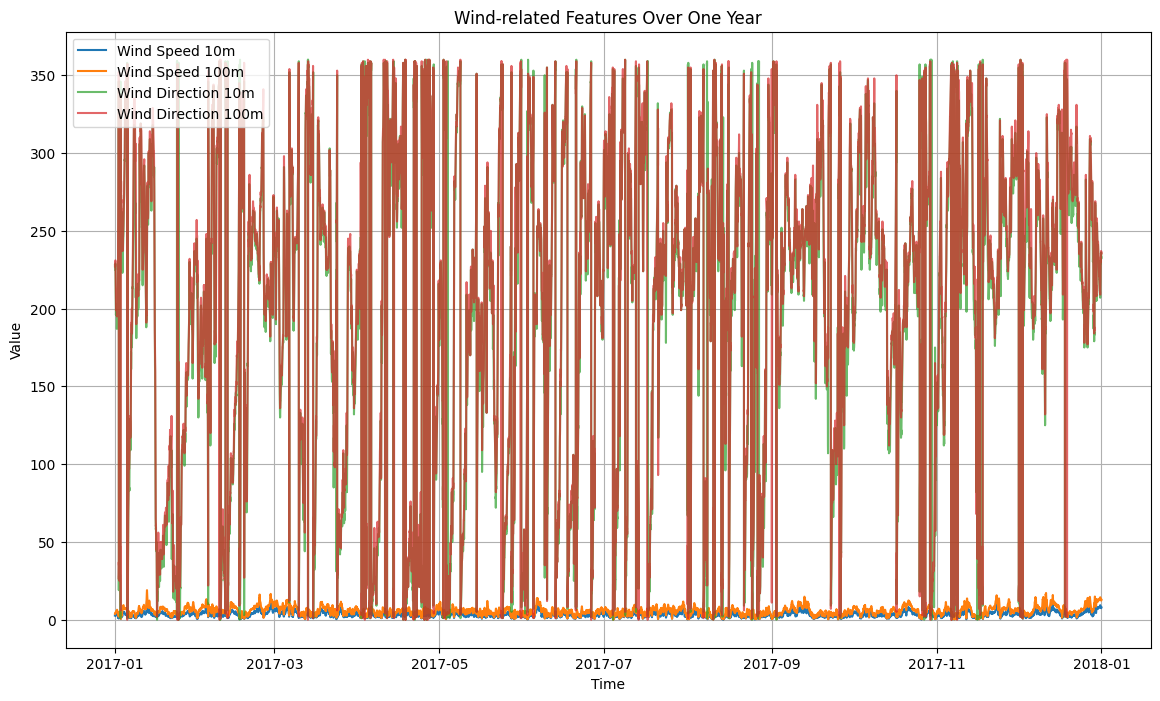

Number of no-wind hours: 0.0
Number of low-wind hours: 631.5


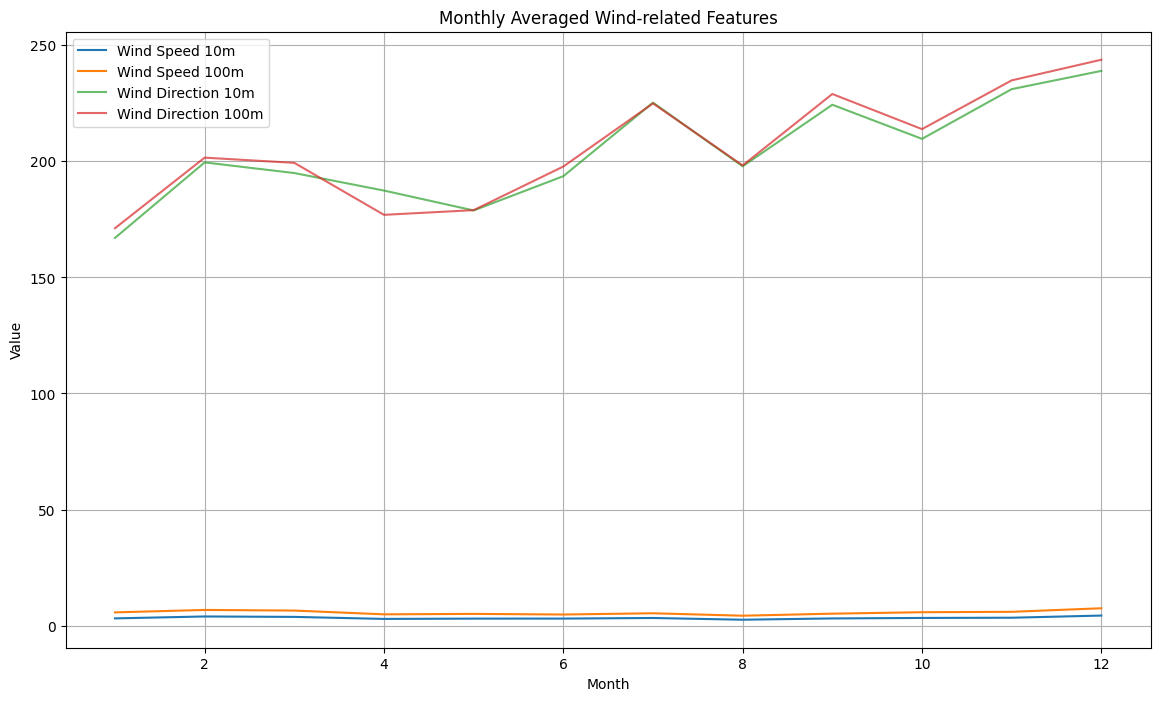

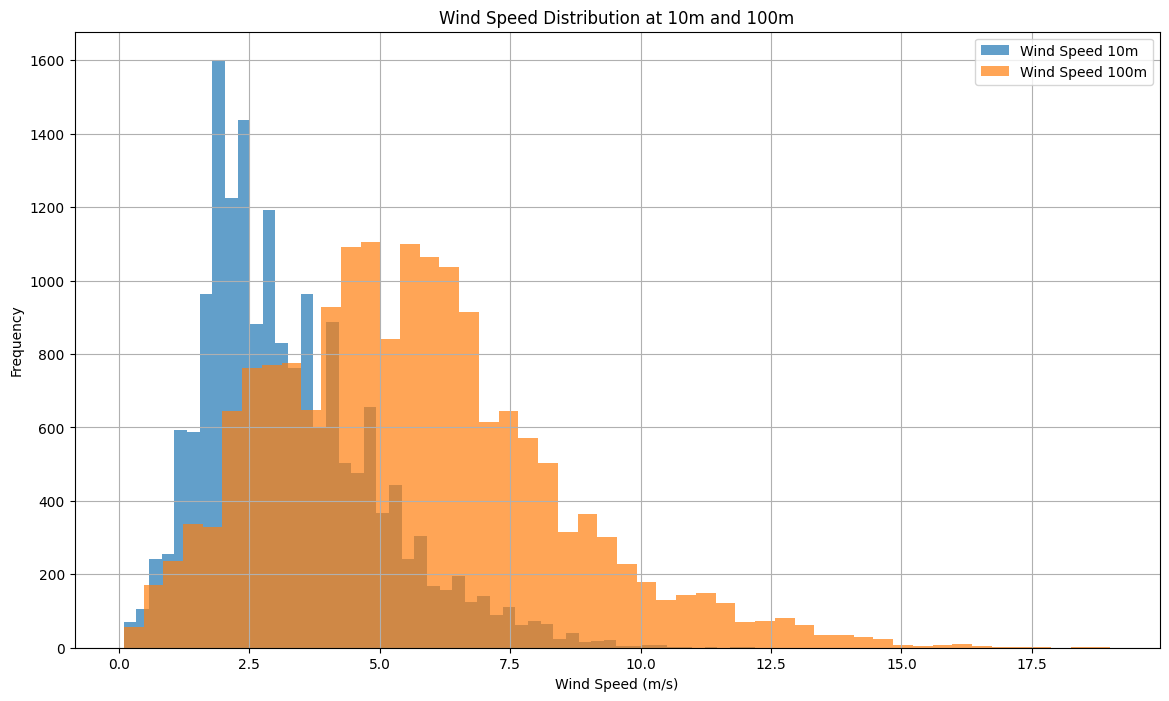

Weibull parameters for 10m: (2.0767991096700786, 0, 3.715193249568682)
Weibull parameters for 100m: (2.1960650350214856, 0, 6.3232097882729175)
Monthly Capacity Factors:
Alstom_ECO122:
month
1     12.506583
2     15.688840
3     15.837224
4      8.515276
5      9.506648
6      8.409125
7     10.983077
8      7.129424
9     10.135136
10    12.958893
11    13.631234
12    20.309613
Name: power_Alstom_ECO122, dtype: float64
Enercon_E33:
month
1      9.180312
2     12.070847
3     12.030701
4      5.923155
5      6.640098
6      5.898013
7      7.981174
8      4.957380
9      7.445948
10     9.596890
11    10.360965
12    15.794483
Name: power_Enercon_E33, dtype: float64
Aventa_AV7:
month
1     10.095554
2     14.842467
3     13.618959
4      5.805348
5      6.599619
6      6.750171
7      8.061769
8      4.845503
9      8.689585
10     9.903441
11    13.322229
12    25.274893
Name: power_Aventa_AV7, dtype: float64


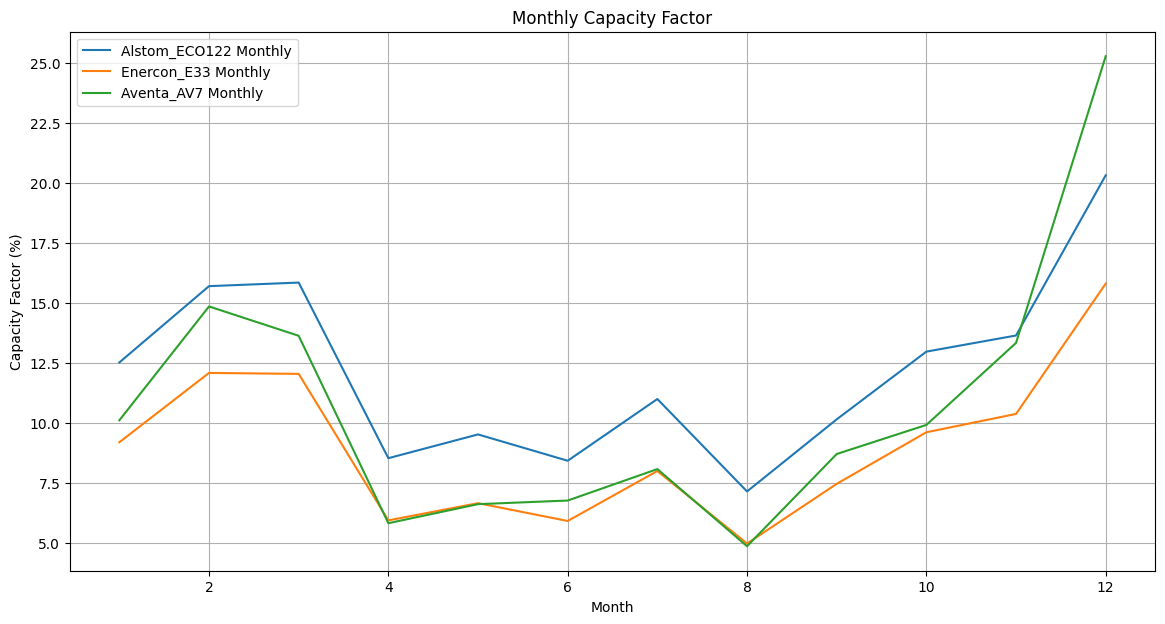

Yearly Capacity Factors:
Alstom_ECO122:
year
2014    12.743985
2015    13.863874
2016    12.136402
2017    11.968033
2018    12.712785
2019    13.952034
2020    15.368036
2021    13.292924
2022    12.703623
2023    15.646268
2024     0.090549
Name: power_Alstom_ECO122, dtype: float64
Enercon_E33:
year
2014     9.494136
2015    10.384173
2016     8.992895
2017     8.866846
2018     9.457204
2019    10.507514
2020    11.702335
2021     9.947753
2022     9.457553
2023    11.912667
2024     0.073024
Name: power_Enercon_E33, dtype: float64
Aventa_AV7:
year
2014    11.170482
2015    12.363182
2016    10.328390
2017    10.504893
2018    11.111645
2019    12.711564
2020    14.752607
2021    11.393890
2022    11.308580
2023    15.079490
2024     0.105097
Name: power_Aventa_AV7, dtype: float64


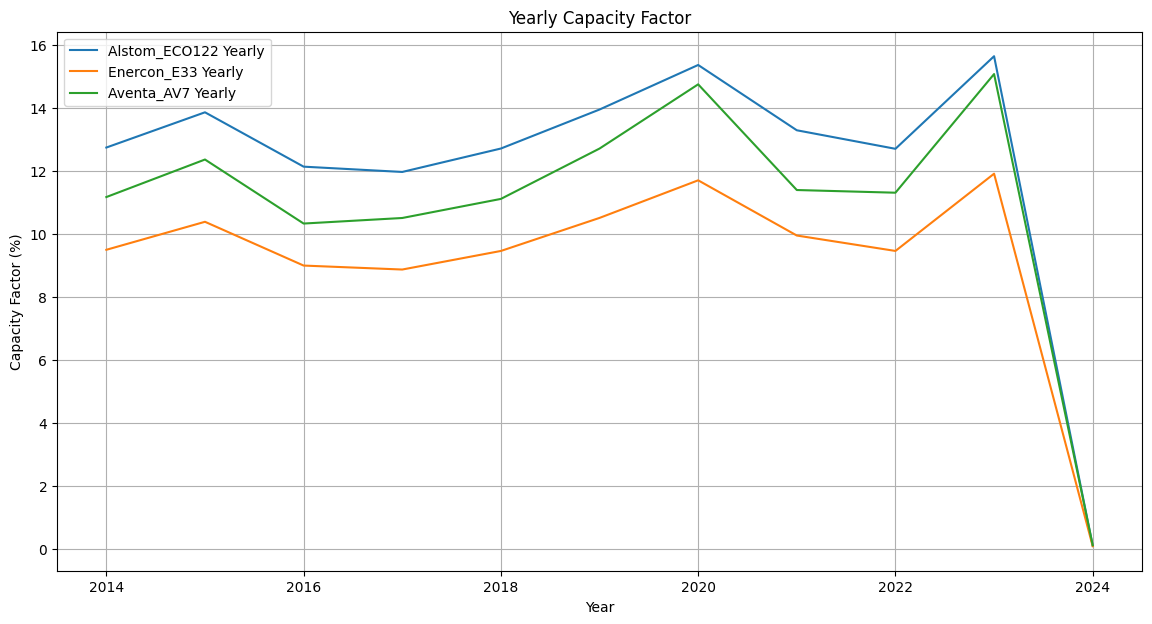

Total Power Production (kWh/year):
{'Alstom_ECO122': 31806857.76416622, 'Enercon_E33': 2957962.311052692, 'Aventa_AV7': 65625.09232740887}

Number of Turbines Needed:
{'Alstom_ECO122': 1348.7657384481208, 'Enercon_E33': 14503.227387211897, 'Aventa_AV7': 653713.3660089718}
The capacity storage needed (kWh/year:)
3092619863.0


In [594]:
def main(file_path, year):
    wind_data = load_and_prepare_data(file_path)
    wind_data_year, results = process_wind_data(wind_data, year)
    wind_data2 = process_wind_data2(wind_data)

    print("Results:")
    print(results)
    
    plot_wind_features(wind_data_year)
    
    low_wind_hours = calculate_low_wind_hours(wind_data_year, threshold=2)
    no_wind_hours = calculate_no_wind_hours(wind_data_year)
    capacity_storage = calculate_storage_capacity(annual_consumption, low_wind_hours)
    print(f"Number of no-wind hours: {no_wind_hours}")
    print(f"Number of low-wind hours: {low_wind_hours}")

    plot_monthly_averages(wind_data_year)
    plot_wind_speed_distribution(wind_data_year)
    
    params_10m, params_100m = fit_weibull_distribution(wind_data_year)
    print(f"Weibull parameters for 10m: {params_10m}")
    print(f"Weibull parameters for 100m: {params_100m}")

    # Power curves defined earlier
    power_curves = {
        'Alstom_ECO122': {'rated_power': 2700, 'cut_in': 3, 'cut_out': 25},
        'Enercon_E33': {'rated_power': 335, 'cut_in': 3, 'cut_out': 25},
        'Aventa_AV7': {'rated_power': 6.2, 'cut_in': 2, 'cut_out': 14}
    }
    
    heights = {
        'Alstom_ECO122': 89, # https://en.wind-turbine-models.com/turbines/629-alstom-eco-122-2700
        'Enercon_E33': 50, # https://en.wind-turbine-models.com/turbines/369-enercon-e-30-330
        'Aventa_AV7': 18 # https://en.wind-turbine-models.com/turbines/1529-aventa-av-7
    }
    
    plot_capacity_factor_month(wind_data_year, heights, power_curves)
    plot_capacity_factor_year(wind_data2, heights, power_curves)
    calculate_turbines_needed(wind_data, annual_consumption)
    print("Total Power Production (kWh/year):")
    print(total_power_production)
    print("\nNumber of Turbines Needed:")
    print(turbines_needed)
    calculate_storage_capacity(annual_consumption, low_wind_hours)
    print("The capacity storage needed (kWh/year:)")
    print(round(capacity_storage, 0))



# Use the main function for a given year
file_path = 'csv_Paris_48.85889_2.320041_fixed_23_180_PT30M.csv'
year = 2017 
main(file_path, year)

# Question for the first part of the code :

Finally, answer to the following question: what is the effect of the wind direction, and how should you take that into account when installing your wind turbine ?

The wind direction affects turbine efficiency, as the wind should hit the blades perpendicularly to maximize energy production. When installing wind turbines, it's crucial to position them according to prevailing wind directions. This requires analyzing wind direction data for the site to optimally orient the turbines.

Questions for the second part of the code :

Finally, produce the analysis that allow you to answer the following open questions : In France, the average electricity consumption per person is 2,223 kWh per person per year (source: INSEE).

# 1- How many wind turbines of each of those kinds would you need to install to safely power the town you have chosen with only wind turbines ?

Paris annual consumption is 42 900 000 GWh

The program below perfom this computation :
It calculates the number of wind turbines needed to meet Paris' annual energy demand of 42900 GWh. It first retrieves the annual energy production for each turbine type (Alstom ECO122, Enercon E33, and Aventa AV7) for the year 2023 using the power_features function. Then, it computes how many of each turbine type are required by dividing the total energy demand by the annual production per turbine and rounding up to the nearest whole number.

Number of Turbines Needed:
{'Alstom_ECO122': 1349, 'Enercon_E33': 14503 'Aventa_AV7': 653713}

# 2- What choice would you make based on cost and feasibility ?

_To power the city of Paris with wind turbines, we need to consider cost, feasibility, and urban constraints. Here's an analysis of the three types of turbines:_

### _Alstom ECO122_
- Number Needed: 1349
- Advantages: High capacity, fewer turbines needed, efficient land use.
- Disadvantages: High initial cost, significant visual impact.

### _Enercon E33_
- Number Needed: 14503
- Advantages: Moderate cost, less visually intrusive.
- Disadvantages: More turbines required, higher cumulative maintenance costs.

### _Aventa AV7_
- Number Needed: 653713
- Advantages: Low cost per turbine.
- Disadvantages: Impractical in urban settings due to the vast number required, significant land use, and high visual impact.

### _Recommendation_

Alstom ECO122 turbines are the optimal choice for Paris. They require fewer units, making them more suitable for urban areas, and despite the higher initial cost, they offer better long-term feasibility and efficiency.

# 3-Assuming this electricity consumption is constant, what storage capacity should your town install to deal with periods without wind ?

The storage capacity Paris should install to deal with periods whitout wind is 3092619863 kWh per year. 




